## **Model Components:**

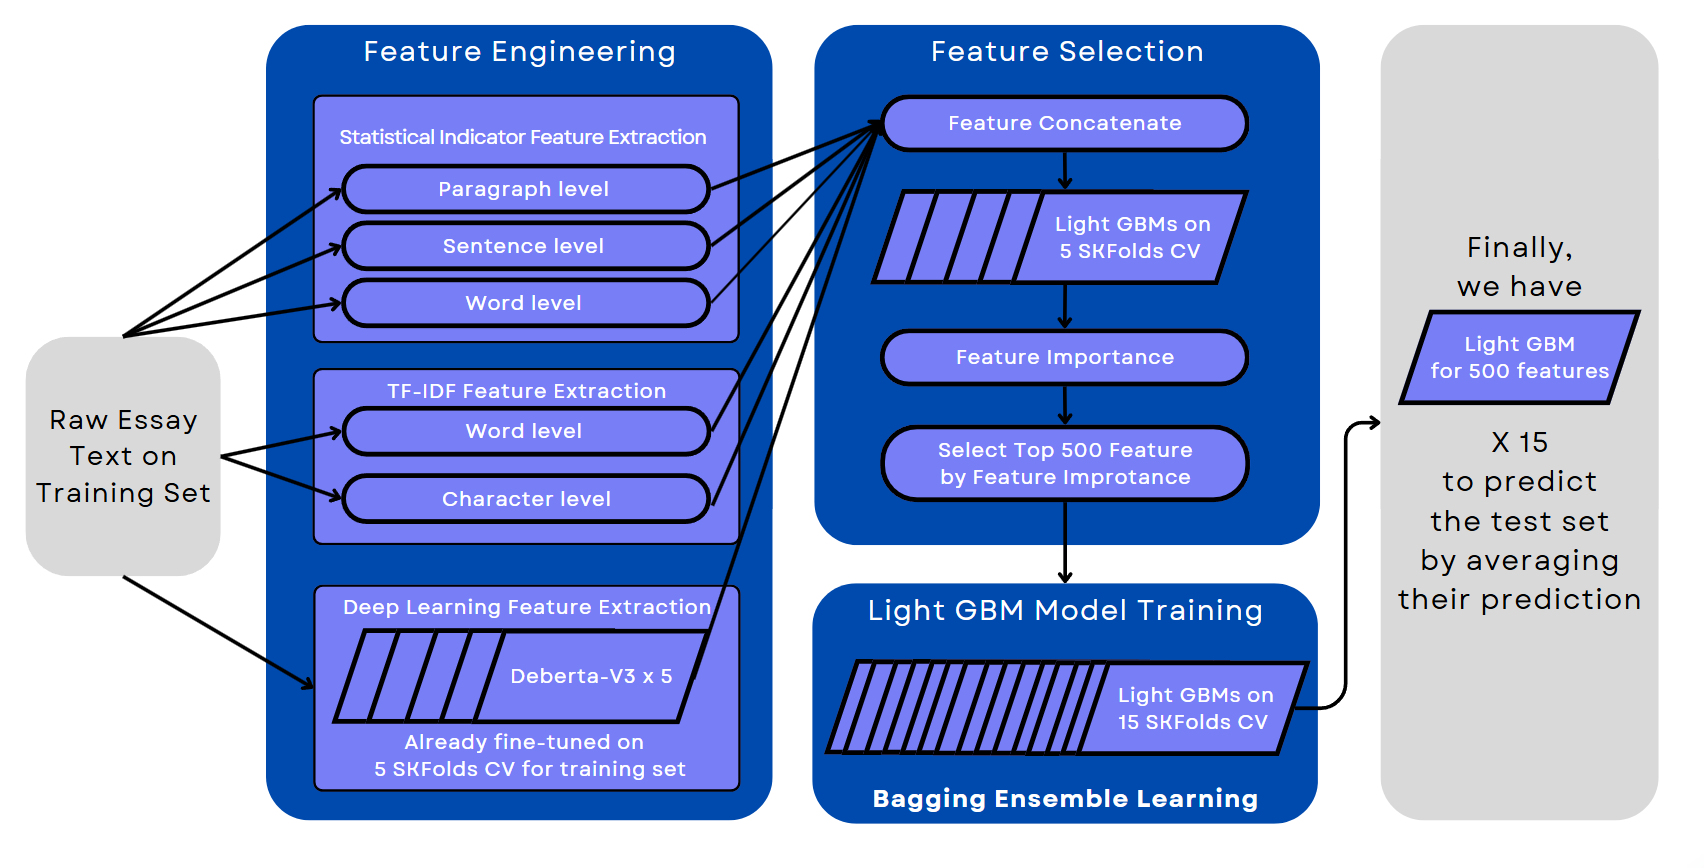

## **Working of the Model:**

1. **Data Preprocessing:** The essay text undergoes preprocessing steps, including lowercasing, HTML tag removal, punctuation removal, spelling error detection, and contraction expansion.

2. **Feature Engineering:** Features are extracted from the preprocessed text, including paragraph length, sentence count, word count, and other linguistic features.

3. **Model Training:** The preprocessed features are fed into the LGBM model along with Deberta embeddings, TF-IDF vectors, and CountVectorizer representations. The model is trained using a combination of these features to learn the scoring patterns.

4. **Cross-Validation:** The model undergoes cross-validation using stratified k-fold technique to ensure robustness and reliability in scoring.

5. **Ensemble Prediction:** Predictions from multiple models trained on different folds are averaged to obtain the final predicted scores for the essays.

6. **Submission Generation:** The predicted scores are then used to generate a submission file in CSV format, which can be used for evaluation or submission in essay scoring competitions.

In [1]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb

2024-07-01 18:56:14.321775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 18:56:14.321885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 18:56:14.445231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Loading for feature extraction

In [2]:
# Define a list of columns transformations
columns = [
    # Split the 'full_text' column by double newline characters to separate paragraphs and alias the result as 'paragraph'
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]

# Define the path to the dataset
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

# Read the training dataset, apply the column transformations, and store the result in 'train'
train = pl.read_csv(PATH + "train.csv").with_columns(columns)

# Read the test dataset, apply the column transformations, and store the result in 'test'
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

## Spelling Error Count Function

In [3]:
import spacy
import re

# Load the small English language model from spaCy
nlp = spacy.load("en_core_web_sm")

# Read the English vocabulary from a file and store it as a set of lowercase words
with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)

def count_spelling_errors(text):
    """
    Count the number of spelling errors in the provided text.

    Parameters:
    text (str): The input text to check for spelling errors.

    Returns:
    int: The number of words in the text that are not found in the English vocabulary.
    """
    # Process the text using spaCy to get tokens and their lemmas
    doc = nlp(text)
    
    # Create a list of lemmatized tokens in lowercase
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    
    # Count the number of tokens that are not in the English vocabulary
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    
    # Return the total count of spelling errors
    return spelling_errors

# Contraction Expansion and Text Preprocessing Functions 

In [4]:
# Dictionary for contractions and their expanded forms
cList = {
    "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have",
    "couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not",
    "hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will",
    "he'll've": "he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is",
    "I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","isn't": "is not",
    "it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam",
    "mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not",
    "mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
    "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would",
    "she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have",
    "shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have",
    "that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would",
    "they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
    "to've": "to have","wasn't": "was not","we'd": "we had","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
    "we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
    "what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is",
    "where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
    "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
    "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would","y'all'd've": "you all would have",
    "y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you will",
    "you'll've": "you will have","you're": "you are","you've": "you have"
}

# Compile a regex pattern for the contractions in cList
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    """
    Expand contractions in the given text based on the cList dictionary.
    
    Parameters:
    text (str): The input text containing contractions.
    c_re (re.Pattern): The compiled regex pattern for matching contractions.
    
    Returns:
    str: The text with contractions expanded.
    """
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    """
    Remove HTML tags from the given text.
    
    Parameters:
    x (str): The input text containing HTML tags.
    
    Returns:
    str: The text with HTML tags removed.
    """
    html = re.compile(r'<.*?>')
    return html.sub(r'', x)

def dataPreprocessing(x):
    """
    Preprocess the input text by performing a series of cleaning steps:
    - Convert to lowercase
    - Remove HTML tags
    - Remove mentions
    - Remove contractions
    - Remove digits
    - Remove URLs
    - Remove extra whitespaces
    - Expand contractions
    - Remove repeated punctuation
    
    Parameters:
    x (str): The input text to preprocess.
    
    Returns:
    str: The cleaned and preprocessed text.
    """
    x = x.lower()  # Convert to lowercase
    x = removeHTML(x)  # Remove HTML tags
    x = re.sub("@\w+", '', x)  # Remove mentions
    x = re.sub("'\d+", '', x)  # Remove contractions
    x = re.sub("\d+", '', x)  # Remove digits
    x = re.sub("http\w+", '', x)  # Remove URLs
    x = re.sub(r"\s+", " ", x)  # Remove extra whitespaces
    x = expandContractions(x)  # Expand contractions
    x = re.sub(r"\.+", ".", x)  # Remove repeated periods
    x = re.sub(r"\,+", ",", x)  # Remove repeated commas
    x = x.strip()  # Remove leading and trailing whitespaces
    return x

# Punctuation Removal Function

In [5]:
import string

def remove_punctuation(text):
    """
    Remove punctuation from the given text.
    
    Parameters:
    text (str): The input text containing punctuation.
    
    Returns:
    str: The text with punctuation removed.
    """
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', string.punctuation)
    # Use the translation table to remove punctuation from the text
    return text.translate(translator)

# Sample text for demonstration
text = "Hello, world! This is a test."
# Print the result of removing punctuation from the sample text
print(remove_punctuation(text))


Hello world This is a test


# Paragraph Preprocessing

In [6]:
def Paragraph_Preprocess(tmp):
    """
    Preprocess paragraphs in the DataFrame by exploding paragraphs, cleaning and processing text,
    and generating various features for each paragraph.
    
    Parameters:
    tmp (pl.DataFrame): The input DataFrame containing essay data.
    
    Returns:
    pl.DataFrame: The processed DataFrame with additional paragraph features.
    """
    # Explode the 'paragraph' column so each row contains a single paragraph
    tmp = tmp.explode('paragraph')
    
    # Apply data preprocessing to each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    
    # Remove punctuation from each paragraph and create a new column 'paragraph_no_punctuation'
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_punctuation'))
    
    # Count spelling errors in each paragraph and create a new column 'paragraph_error_num'
    tmp = tmp.with_columns(pl.col('paragraph_no_punctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    
    # Calculate the length of each paragraph and create a new column 'paragraph_len'
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    
    # Count the number of sentences in each paragraph and create a new column 'paragraph_sentence_cnt'
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                           # Count the number of words in each paragraph and create a new column 'paragraph_word_cnt'
                           pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"))
    
    return tmp

# List of paragraph features to be generated
paragraph_fea = ['paragraph_len', 'paragraph_sentence_cnt', 'paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea

def Paragraph_Eng(train_tmp):
    """
    Aggregate paragraph features by essay and generate summary statistics.
    
    Parameters:
    train_tmp (pl.DataFrame): The input DataFrame containing preprocessed paragraph data.
    
    Returns:
    pd.DataFrame: The DataFrame with aggregated paragraph features.
    """
    num_list = [0, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600]
    num_list2 = [0, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600, 700]
    
    # Define aggregations for paragraph features
    aggs = [
        # Count the number of paragraphs with length >= each value in num_list2
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_>{i}_cnt") for i in num_list2],
        # Count the number of paragraphs with length <= each value in [25, 49]
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_<{i}_cnt") for i in [25, 49]],

        # Calculate max, mean, min, sum, first, last, kurtosis, and quantiles for each feature in paragraph_fea2
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  # Calculate first quartile
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  # Calculate third quartile
    ]
    
    # Group by 'essay_id', perform aggregations, and convert to pandas DataFrame
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

def read_or_compute_features(features_path, train):
    """
    Read precomputed features from a CSV file or compute features if the file does not exist.
    
    Parameters:
    features_path (str): The path to the CSV file containing precomputed features.
    train (pl.DataFrame): The input training DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame with computed or loaded features.
    """
    import os
    if os.path.exists(features_path):
        print("CSV file found. Reading the data...")
        return pd.read_csv(features_path)
    else:
        print("CSV file not found. Performing calculation...")
        tmp = Paragraph_Preprocess(train)
        return Paragraph_Eng(tmp)

# Path to the precomputed features file
fea_path = "/kaggle/input/aes-computed-features/paragraph_features.csv"
# Read or compute features
train_feats = read_or_compute_features(fea_path, train)
# Add the 'score' column to the features DataFrame
train_feats['score'] = train['score']
# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))
print('Features Number: ', len(feature_names))


CSV file found. Reading the data...
Features Number:  53


# Sentence Preprocessing

In [7]:
def Sentence_Preprocess(tmp):
    """
    Preprocess sentences in the DataFrame by cleaning and processing text,
    splitting it into sentences, and generating various features for each sentence.
    
    Parameters:
    tmp (pl.DataFrame): The input DataFrame containing essay data.
    
    Returns:
    pl.DataFrame: The processed DataFrame with additional sentence features.
    """
    # Apply data preprocessing to 'full_text' and split it into sentences by punctuation marks
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=r"[.!?]").alias("sentence"))
    
    # Explode the 'sentence' column so each row contains a single sentence
    tmp = tmp.explode('sentence')
    
    # Calculate the length of each sentence and create a new column 'sentence_len'
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))

    # Count the number of words in each sentence and create a new column 'sentence_word_cnt'
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp

# List of sentence features to be generated
sentence_fea = ['sentence_len', 'sentence_word_cnt']

def Sentence_Eng(train_tmp):
    """
    Aggregate sentence features by essay and generate summary statistics.
    
    Parameters:
    train_tmp (pl.DataFrame): The input DataFrame containing preprocessed sentence data.
    
    Returns:
    pd.DataFrame: The DataFrame with aggregated sentence features.
    """
    aggs = [
        # Count the number of sentences with length >= each value in [0, 15, 50, 100, 150, 200, 250, 300]
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_>{i}_cnt") for i in [0, 15, 50, 100, 150, 200, 250, 300]], 
        # Count the number of sentences with length <= each value in [15, 50]
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15, 50]], 

        # Calculate max, mean, min, sum, first, last, kurtosis, and quantiles for each feature in sentence_fea
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea],  # Calculate first quartile
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea],  # Calculate third quartile
    ]
    
    # Group by 'essay_id', perform aggregations, and convert to pandas DataFrame
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

# Preprocess sentences in the training data
tmp = Sentence_Preprocess(train)

# Merge sentence features with the existing features DataFrame
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))
print('Features Number: ', len(feature_names))


Features Number:  81


# Word Preprocessing

In [8]:
def Word_Preprocess(tmp):
    """
    Preprocess words in the DataFrame by cleaning and processing text,
    splitting it into words, and generating various features for each word.
    
    Parameters:
    tmp (pl.DataFrame): The input DataFrame containing essay data.
    
    Returns:
    pl.DataFrame: The processed DataFrame with additional word features.
    """
    # Apply data preprocessing to 'full_text' and split it into words by spaces
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    
    # Explode the 'word' column so each row contains a single word
    tmp = tmp.explode('word')
    
    # Calculate the length of each word and create a new column 'word_len'
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    
    # Filter out rows where 'word_len' is 0 (i.e., remove empty words)
    tmp = tmp.filter(pl.col('word_len') != 0)
    
    return tmp

def Word_Eng(train_tmp):
    """
    Aggregate word features by essay and generate summary statistics.
    
    Parameters:
    train_tmp (pl.DataFrame): The input DataFrame containing preprocessed word data.
    
    Returns:
    pd.DataFrame: The DataFrame with aggregated word features.
    """
    aggs = [
        # Count the number of words with length >= each value in [1, 2, ..., 15]
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15)],
        
        # Calculate max, mean, standard deviation, and quantiles for word length
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),  # Calculate first quartile
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),  # Calculate median
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),  # Calculate third quartile
    ]
    
    # Group by 'essay_id', perform aggregations, and convert to pandas DataFrame
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

# Preprocess words in the training data
tmp = Word_Preprocess(train)

# Merge word features with the existing features DataFrame
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))
print('Features Number: ', len(feature_names))


Features Number:  102


# Tf-idf Vectorizer Setup and Feature Engineering

In [9]:
# Initialize a TfidfVectorizer for word-level TF-IDF features
vectorizerWord = TfidfVectorizer(
    preprocessor=lambda x: x,  # Use the raw input as is, without additional preprocessing
    strip_accents='unicode',   # Normalize unicode characters
    analyzer='word',           # Perform word-level analysis
    ngram_range=(1, 5),        # Consider n-grams from 1 to 5 words
    min_df=0.05,               # Ignore terms with a document frequency lower than 5%
    max_df=0.95,               # Ignore terms with a document frequency higher than 95%
    sublinear_tf=True,         # Apply sublinear TF scaling
)

# Fit the vectorizer on the training data and transform the text data into TF-IDF features
train_tfid = vectorizerWord.fit_transform([i for i in train['full_text']])

# Convert the sparse TF-IDF matrix to a dense array
dense_matrix = train_tfid.toarray()

# Create a DataFrame from the dense TF-IDF matrix
df = pd.DataFrame(dense_matrix)

# Create column names for the TF-IDF features
tfid_columns = [f'tfidw_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns

# Add 'essay_id' to the TF-IDF DataFrame for merging
df['essay_id'] = train_feats['essay_id']

# Merge the TF-IDF features with the existing features DataFrame
train_feats = train_feats.merge(df, on='essay_id', how='left')

# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))
print('Number of Features: ', len(feature_names))

Number of Features:  1300


In [10]:
# Initialize a TfidfVectorizer for character-level TF-IDF features
vectorizerChar = TfidfVectorizer(
    tokenizer=lambda x: x,      # Use the raw input as is, without additional tokenization
    preprocessor=lambda x: x,   # Use the raw input as is, without additional preprocessing
    token_pattern=None,         # Ignore token patterns and use the provided tokenizer
    strip_accents='unicode',    # Normalize unicode characters
    analyzer='char',            # Perform character-level analysis
    ngram_range=(2, 6),         # Consider n-grams from 2 to 6 characters
    min_df=0.05,                # Ignore n-grams with a document frequency lower than 5%
    max_df=0.95,                # Ignore n-grams with a document frequency higher than 95%
    sublinear_tf=True,          # Apply sublinear TF scaling
)

# Fit the vectorizer on the training data and transform the text data into TF-IDF features
train_tfid = vectorizerChar.fit_transform([i for i in train['full_text']])

# Convert the sparse TF-IDF matrix to a dense array
dense_matrix = train_tfid.toarray()

# Create a DataFrame from the dense TF-IDF matrix
df = pd.DataFrame(dense_matrix)

# Create column names for the TF-IDF features
tfid_columns = [f'tfidc_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns

# Add 'essay_id' to the TF-IDF DataFrame for merging
df['essay_id'] = train_feats['essay_id']

# Merge the TF-IDF features with the existing features DataFrame
train_feats = train_feats.merge(df, on='essay_id', how='left')

# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))
print('Number of Features: ', len(feature_names))

Number of Features:  21411


# Deberta OOF Prediction as Features

In [11]:
import joblib

# Load out-of-fold (OOF) predictions from a DeBERTa model
deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')

# Print the shapes of the DeBERTa OOF predictions and the training features DataFrame
print(deberta_oof.shape, train_feats.shape)

# Add the DeBERTa OOF predictions as new columns to the training features DataFrame
for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

# Filter out 'essay_id' and 'score' from the list of feature names
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))

# Print the number of features
print('Features Number: ', len(feature_names))

# Print the shape of the updated training features DataFrame
train_feats.shape

(17307, 6) (17307, 21413)
Features Number:  21417


(17307, 21419)

# QWK Metric Definitions and Parameters 

In [12]:
# Define a function to calculate the quadratic weighted kappa (QWK) metric
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate the quadratic weighted kappa (QWK) between the true and predicted values.
    
    Parameters:
    y_true (array-like): The true values.
    y_pred (array-like): The predicted values.
    
    Returns:
    tuple: A tuple containing the string 'QWK', the QWK value, and a boolean True.
    """
    y_true = y_true + a  # Adjust the true values with constant 'a'
    y_pred = (y_pred + a).clip(1, 6).round()  # Adjust, clip, and round the predicted values
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")  # Calculate QWK
    return 'QWK', qwk, True

# Define a custom objective function for optimization
def qwk_obj(y_true, y_pred):
    """
    Custom objective function for optimizing QWK.
    
    Parameters:
    y_true (array-like): The true values.
    y_pred (array-like): The predicted values.
    
    Returns:
    tuple: Gradients and Hessians for the optimization process.
    """
    labels = y_true + a  # Adjust the true values with constant 'a'
    preds = y_pred + a  # Adjust the predicted values with constant 'a'
    preds = preds.clip(1, 6)  # Clip the predicted values within the range [1, 6]
    
    # Calculate the loss function and its gradients
    f = 1/2 * np.sum((preds - labels) ** 2)
    g = 1/2 * np.sum((preds - a) ** 2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df / g - f * dg / g ** 2) * len(labels)
    hess = np.ones(len(labels))  # Use a constant Hessian of ones
    
    return grad, hess

# Constants used in the QWK and custom objective functions
a = 2.998
b = 1.092

## Data Preparation for Model Training

In [13]:
# Extract feature values from the training features DataFrame, convert to float32, and store in array X
X = train_feats[feature_names].astype(np.float32).values

# Extract the 'score' column, convert to integers, and store in array y_split for splitting or cross-validation
y_split = train_feats['score'].astype(int).values

# Extract the 'score' column, convert to float32, adjust by subtracting constant 'a', and store in array y
y = train_feats['score'].astype(np.float32).values - a

# Extract the 'score' column, convert to integers, and store in array oof for out-of-fold predictions
oof = train_feats['score'].astype(int).values

# Feature Selection Wrapper Function

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.778212	valid's QWK: 0.775444
[50]	train's QWK: 0.826178	valid's QWK: 0.80644
[75]	train's QWK: 0.834629	valid's QWK: 0.818282
[100]	train's QWK: 0.840238	valid's QWK: 0.824164
[125]	train's QWK: 0.842942	valid's QWK: 0.827648
[150]	train's QWK: 0.8459	valid's QWK: 0.82926
[175]	train's QWK: 0.848413	valid's QWK: 0.831647
[200]	train's QWK: 0.850965	valid's QWK: 0.831832
[225]	train's QWK: 0.852834	valid's QWK: 0.833587
[250]	train's QWK: 0.855287	valid's QWK: 0.835209
[275]	train's QWK: 0.857628	valid's QWK: 0.834223
[300]	train's QWK: 0.859477	valid's QWK: 0.834983
[325]	train's QWK: 0.861147	valid's QWK: 0.834515
Early stopping, best iteration is:
[253]	train's QWK: 0.855711	valid's QWK: 0.835659
Evaluated only: QWK


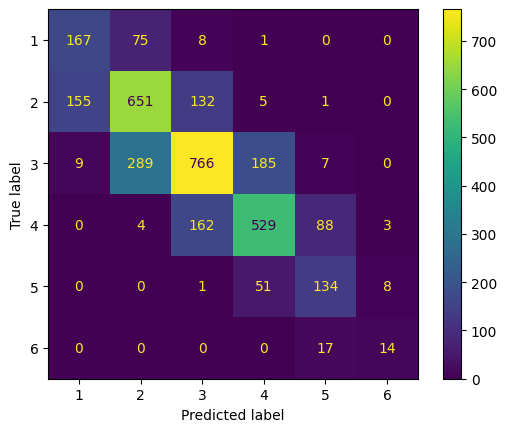

F1 score across fold: 0.6543251076592689
Cohen kappa score across fold: 0.8356585691329925
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.783736	valid's QWK: 0.778029
[50]	train's QWK: 0.824986	valid's QWK: 0.81997
[75]	train's QWK: 0.833962	valid's QWK: 0.826313
[100]	train's QWK: 0.840043	valid's QWK: 0.831578
[125]	train's QWK: 0.843478	valid's QWK: 0.833475
[150]	train's QWK: 0.845682	valid's QWK: 0.835264
[175]	train's QWK: 0.848669	valid's QWK: 0.833911
[200]	train's QWK: 0.85044	valid's QWK: 0.83461
[225]	train's QWK: 0.852488	valid's QWK: 0.833432
[250]	train's QWK: 0.85549	valid's QWK: 0.834688
Early stopping, best iteration is:
[187]	train's QWK: 0.849383	valid's QWK: 0.835471
Evaluated only: QWK


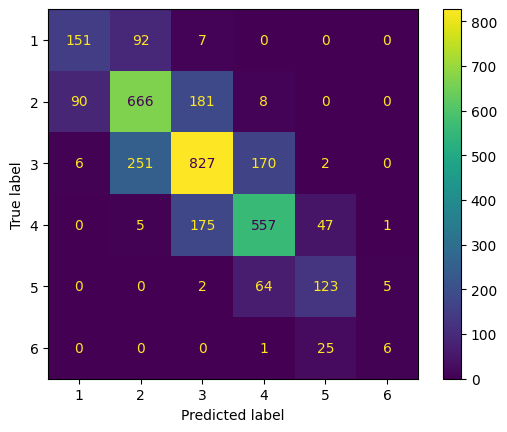

F1 score across fold: 0.671746603843216
Cohen kappa score across fold: 0.8354710982990039
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.787907	valid's QWK: 0.760842
[50]	train's QWK: 0.831399	valid's QWK: 0.808746
[75]	train's QWK: 0.839855	valid's QWK: 0.8181
[100]	train's QWK: 0.843571	valid's QWK: 0.821558
[125]	train's QWK: 0.847025	valid's QWK: 0.8235
[150]	train's QWK: 0.850026	valid's QWK: 0.825875
[175]	train's QWK: 0.852571	valid's QWK: 0.827203
[200]	train's QWK: 0.854796	valid's QWK: 0.827202
[225]	train's QWK: 0.856969	valid's QWK: 0.827499
[250]	train's QWK: 0.859178	valid's QWK: 0.828437
[275]	train's QWK: 0.861021	valid's QWK: 0.82785
[300]	train's QWK: 0.863153	valid's QWK: 0.82685
Early stopping, best iteration is:
[246]	train's QWK: 0.859036	valid's QWK: 0.828687
Evaluated only: QWK


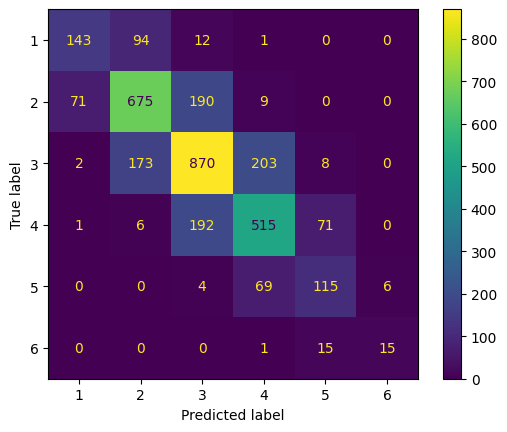

F1 score across fold: 0.6738728141562627
Cohen kappa score across fold: 0.8286873396916858
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.785756	valid's QWK: 0.782411
[50]	train's QWK: 0.822605	valid's QWK: 0.81712
[75]	train's QWK: 0.83309	valid's QWK: 0.824221
[100]	train's QWK: 0.839795	valid's QWK: 0.828402
[125]	train's QWK: 0.843567	valid's QWK: 0.829522
[150]	train's QWK: 0.847396	valid's QWK: 0.830613
[175]	train's QWK: 0.850938	valid's QWK: 0.829465
[200]	train's QWK: 0.853972	valid's QWK: 0.830727
[225]	train's QWK: 0.857188	valid's QWK: 0.833087
[250]	train's QWK: 0.859882	valid's QWK: 0.831589
[275]	train's QWK: 0.862418	valid's QWK: 0.833277
[300]	train's QWK: 0.864703	valid's QWK: 0.833714
[325]	train's QWK: 0.866549	valid's QWK: 0.834407
[350]	train's QWK: 0.868217	valid's QWK: 0.83306
[375]	train's QWK: 0.870142	valid's QWK: 0.833641
[400]	train's QWK: 0.871726	valid's QWK: 0.83396

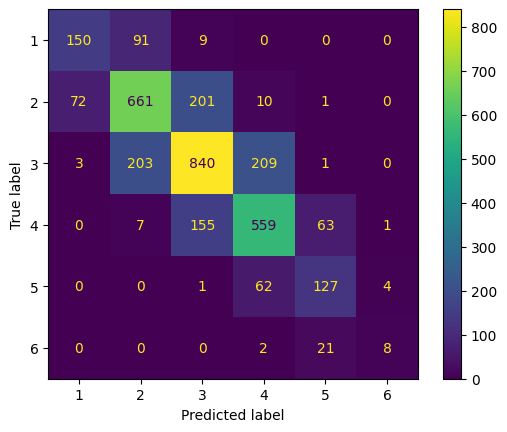

F1 score across fold: 0.6766314997150089
Cohen kappa score across fold: 0.8353730199264794
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.782846	valid's QWK: 0.796338
[50]	train's QWK: 0.823035	valid's QWK: 0.83361
[75]	train's QWK: 0.832574	valid's QWK: 0.837627
[100]	train's QWK: 0.839308	valid's QWK: 0.838878
[125]	train's QWK: 0.843621	valid's QWK: 0.840366
[150]	train's QWK: 0.847254	valid's QWK: 0.839622
[175]	train's QWK: 0.850319	valid's QWK: 0.839967
Early stopping, best iteration is:
[124]	train's QWK: 0.843626	valid's QWK: 0.840823
Evaluated only: QWK


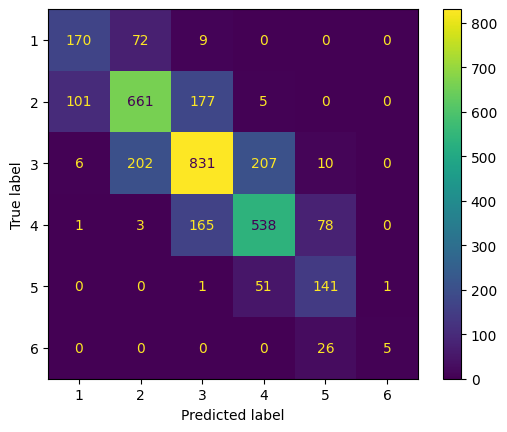

F1 score across fold: 0.6770001874010698
Cohen kappa score across fold: 0.8408230388154544


In [14]:
# Initialize lists to store model performance metrics and predictions
f1_scores = []
kappa_scores = []
models = []
predictions = []

# Define callbacks for LightGBM training
callbacks = [
    log_evaluation(period=25),  # Log evaluation results every 25 iterations
    early_stopping(stopping_rounds=75, first_metric_only=True)  # Early stopping if no improvement in 75 rounds
]

def feature_select_wrapper():
    """
    Perform feature selection using a LightGBM regressor with a custom objective function.
    
    The function trains the model on multiple folds of the data, evaluates performance,
    and aggregates feature importances to select the top features.
    
    Returns:
    list: A list of the top 500 selected features based on their importances.
    """
    features = feature_names
    
    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Initialize a Series to store feature importances
    fse = pd.Series(0, index=features)
    
    # Lists to store model performance metrics
    models = []
    predictions = []
    f1_scores = []
    kappa_scores = []
    
    for train_index, test_index in skf.split(X, y_split):
        # Split the data into training and testing sets for the current fold
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        # Initialize the LightGBM regressor with specified hyperparameters
        model = lgb.LGBMRegressor(
            objective=qwk_obj,
            metrics='None',
            learning_rate=0.05,
            max_depth=5,
            num_leaves=10,
            colsample_bytree=0.3,
            reg_alpha=0.7,
            reg_lambda=0.1,
            n_estimators=700,
            random_state=412,
            extra_trees=True,
            class_weight='balanced',
            verbosity=-1
        )

        # Train the model on the training fold and validate on the test fold
        predictor = model.fit(
            X_train_fold,
            y_train_fold,
            eval_names=['train', 'valid'],
            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
            eval_metric=quadratic_weighted_kappa,
            callbacks=callbacks
        )
        models.append(predictor)

        # Make predictions on the test fold
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        oof[test_index] = predictions_fold
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)

        # Calculate F1 score and Cohen kappa score for the fold
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)
        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        # Plot the confusion matrix for the fold
        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1, 7)])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(1, 7)])
        disp.plot()
        plt.show()
        
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')

        # Aggregate feature importances
        fse += pd.Series(predictor.feature_importances_, index=features)

    # Select the top 500 features based on their importances
    feature_select = fse.sort_values(ascending=False).index.tolist()[:500]
    return feature_select

# Perform feature selection and get the top features
feature_select = feature_select_wrapper()
X = train_feats[feature_select].astype(np.float32).values

# Model Evaluation Metrics Calculation

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.773555	valid's QWK: 0.763816
[50]	train's QWK: 0.821538	valid's QWK: 0.811299
[75]	train's QWK: 0.831755	valid's QWK: 0.816915
[100]	train's QWK: 0.837146	valid's QWK: 0.827964
[125]	train's QWK: 0.840251	valid's QWK: 0.829822
[150]	train's QWK: 0.844056	valid's QWK: 0.831513
[175]	train's QWK: 0.846607	valid's QWK: 0.833014
[200]	train's QWK: 0.849501	valid's QWK: 0.834944
[225]	train's QWK: 0.85093	valid's QWK: 0.833944
[250]	train's QWK: 0.852416	valid's QWK: 0.834711
[275]	train's QWK: 0.854328	valid's QWK: 0.835412
[300]	train's QWK: 0.855587	valid's QWK: 0.837099
[325]	train's QWK: 0.857503	valid's QWK: 0.83843
[350]	train's QWK: 0.859084	valid's QWK: 0.838882
[375]	train's QWK: 0.859964	valid's QWK: 0.838165
[400]	train's QWK: 0.861761	valid's QWK: 0.838954
[425]	train's QWK: 0.863171	valid's QWK: 0.838032
[450]	train's QWK: 0.864776	val

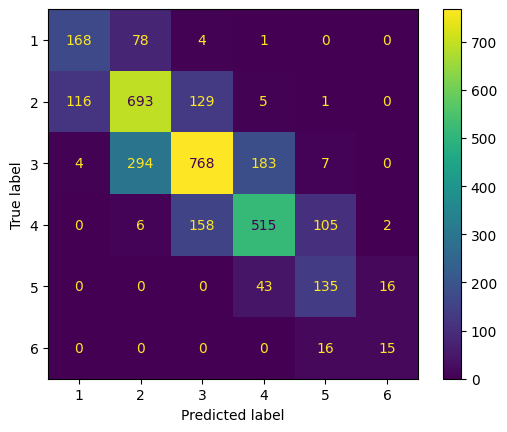

F1 score across fold: 0.6632420808615853
Cohen kappa score across fold: 0.8431424844056012
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.769573	valid's QWK: 0.769054
[50]	train's QWK: 0.819093	valid's QWK: 0.814051
[75]	train's QWK: 0.830507	valid's QWK: 0.823827
[100]	train's QWK: 0.836832	valid's QWK: 0.831106
[125]	train's QWK: 0.84121	valid's QWK: 0.832571
[150]	train's QWK: 0.843955	valid's QWK: 0.833402
[175]	train's QWK: 0.84582	valid's QWK: 0.836024
[200]	train's QWK: 0.847498	valid's QWK: 0.837351
[225]	train's QWK: 0.849351	valid's QWK: 0.837182
[250]	train's QWK: 0.851359	valid's QWK: 0.838321
[275]	train's QWK: 0.852561	valid's QWK: 0.839777
[300]	train's QWK: 0.85458	valid's QWK: 0.840308
[325]	train's QWK: 0.855512	valid's QWK: 0.83831
[350]	train's QWK: 0.856812	valid's QWK: 0.840948
[375]	train's QWK: 0.858948	valid's QWK: 0.83905
[400]	train's QWK: 0.860108	valid's QWK: 0.

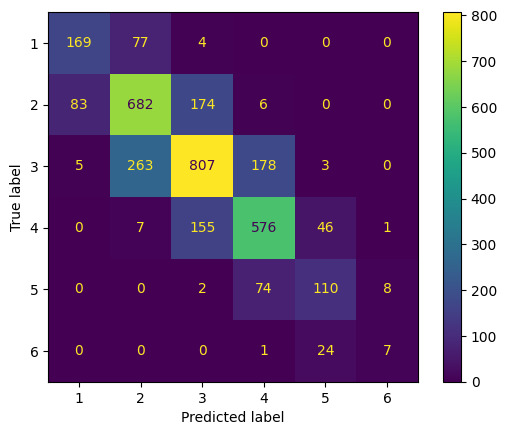

F1 score across fold: 0.6775779795176456
Cohen kappa score across fold: 0.840947569112564
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.772013	valid's QWK: 0.757073
[50]	train's QWK: 0.825315	valid's QWK: 0.803449
[75]	train's QWK: 0.834901	valid's QWK: 0.813648
[100]	train's QWK: 0.839966	valid's QWK: 0.81964
[125]	train's QWK: 0.842781	valid's QWK: 0.821208
[150]	train's QWK: 0.845774	valid's QWK: 0.82301
[175]	train's QWK: 0.8485	valid's QWK: 0.824231
[200]	train's QWK: 0.851265	valid's QWK: 0.825084
[225]	train's QWK: 0.852491	valid's QWK: 0.826757
[250]	train's QWK: 0.854141	valid's QWK: 0.829795
[275]	train's QWK: 0.856222	valid's QWK: 0.830158
[300]	train's QWK: 0.85654	valid's QWK: 0.830717
[325]	train's QWK: 0.858197	valid's QWK: 0.829564
[350]	train's QWK: 0.859392	valid's QWK: 0.831166
[375]	train's QWK: 0.860579	valid's QWK: 0.8324
[400]	train's QWK: 0.862393	valid's QWK: 0.831

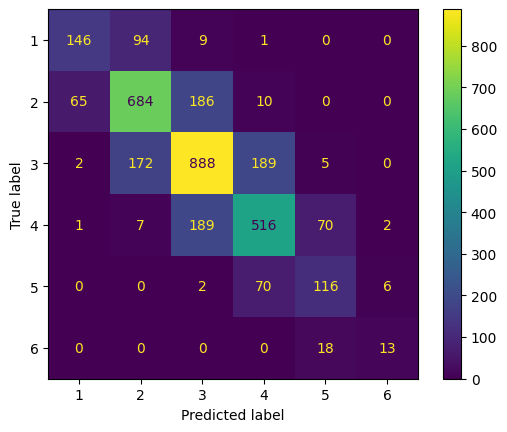

F1 score across fold: 0.682331196518886
Cohen kappa score across fold: 0.8343877153026107
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.772687	valid's QWK: 0.769167
[50]	train's QWK: 0.825995	valid's QWK: 0.818145
[75]	train's QWK: 0.834979	valid's QWK: 0.828858
[100]	train's QWK: 0.839559	valid's QWK: 0.832607
[125]	train's QWK: 0.842103	valid's QWK: 0.833397
[150]	train's QWK: 0.845233	valid's QWK: 0.833827
[175]	train's QWK: 0.846959	valid's QWK: 0.8354
[200]	train's QWK: 0.849511	valid's QWK: 0.835202
[225]	train's QWK: 0.851077	valid's QWK: 0.835923
[250]	train's QWK: 0.853011	valid's QWK: 0.838209
[275]	train's QWK: 0.85453	valid's QWK: 0.838993
[300]	train's QWK: 0.85638	valid's QWK: 0.83871
[325]	train's QWK: 0.857733	valid's QWK: 0.839017
[350]	train's QWK: 0.859603	valid's QWK: 0.83916
[375]	train's QWK: 0.861196	valid's QWK: 0.838872
[400]	train's QWK: 0.862638	valid's QWK: 0.83

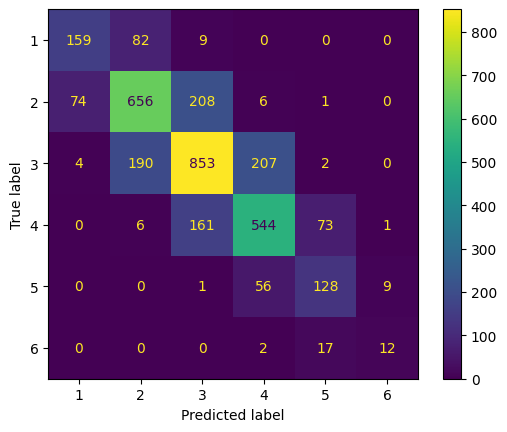

F1 score across fold: 0.6795212408596001
Cohen kappa score across fold: 0.8398455686340678
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.775432	valid's QWK: 0.78665
[50]	train's QWK: 0.822042	valid's QWK: 0.830056
[75]	train's QWK: 0.832212	valid's QWK: 0.83507
[100]	train's QWK: 0.837751	valid's QWK: 0.838176
[125]	train's QWK: 0.841275	valid's QWK: 0.841543
[150]	train's QWK: 0.8437	valid's QWK: 0.841694
[175]	train's QWK: 0.846952	valid's QWK: 0.8414
[200]	train's QWK: 0.849586	valid's QWK: 0.843661
[225]	train's QWK: 0.852018	valid's QWK: 0.844063
[250]	train's QWK: 0.853301	valid's QWK: 0.843909
[275]	train's QWK: 0.855182	valid's QWK: 0.845131
[300]	train's QWK: 0.856692	valid's QWK: 0.845229
[325]	train's QWK: 0.857691	valid's QWK: 0.847446
[350]	train's QWK: 0.858551	valid's QWK: 0.847778
[375]	train's QWK: 0.859618	valid's QWK: 0.847999
[400]	train's QWK: 0.860704	valid's QWK: 0.8

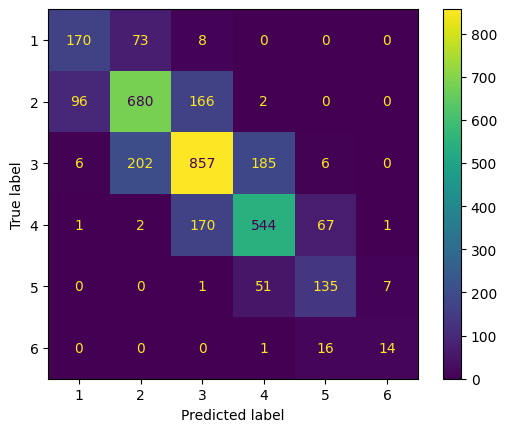

F1 score across fold: 0.69356317658673
Cohen kappa score across fold: 0.8505051496030235
Mean F1 score across 5 folds: 0.6792471348688893
Mean Cohen kappa score across 5 folds: 0.8417656974115735


In [15]:
# Define the number of splits for cross-validation
n_splits = 5

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# Initialize lists to store model performance metrics and predictions
f1_scores = []
kappa_scores = []
models = []
predictions = []

# Define callbacks for LightGBM training
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75, first_metric_only=True)]

# Initialize out-of-fold predictions array
oof = np.zeros(len(train_feats))

# Iterate through each fold in the cross-validation
for i, (train_index, test_index) in enumerate(skf.split(X, y_split), start=1):
    print('fold', i)
    
    # Split the data into training and testing sets for the current fold
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    # Initialize the LightGBM regressor with specified hyperparameters
    model = lgb.LGBMRegressor(
        objective=qwk_obj,
        metrics='None',
        learning_rate=0.05,
        max_depth=5,
        num_leaves=10,
        colsample_bytree=0.3,
        reg_alpha=0.7,
        reg_lambda=0.1,
        n_estimators=700,
        random_state=42,
        extra_trees=True,
        class_weight='balanced',
        verbosity=-1
    )

    # Train the model on the training fold and validate on the test fold
    predictor = model.fit(
        X_train_fold,
        y_train_fold,
        eval_names=['train', 'valid'],
        eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
        eval_metric=quadratic_weighted_kappa,
        callbacks=callbacks
    )
    models.append(predictor)

    # Make predictions on the test fold
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index] = predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)

    # Calculate F1 score and Cohen kappa score for the fold
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)

    # Plot the confusion matrix for the fold
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1, 7)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(1, 7)])
    disp.plot()
    plt.show()
    
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')

# Calculate mean F1 score and Cohen kappa score across all folds
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [16]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

# **Inference**

In [17]:
# Define constants
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1

# Get a list of model paths
deberta_models = glob(MODEL_PATH)

# Load the tokenizer from the first model
tokenizer = AutoTokenizer.from_pretrained(deberta_models[0])

def tokenize(sample):
    """
    Tokenize the text in the sample using the pre-trained tokenizer.
    
    Parameters:
    sample (dict): A dictionary containing the text to tokenize.
    
    Returns:
    dict: A dictionary containing the tokenized text.
    """
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

# Load and preprocess the test data
df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

# Define evaluation arguments
args = TrainingArguments(
    output_dir=".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

# Initialize a list to store predictions
predictions = []

# Iterate through each model and make predictions
for model_path in deberta_models:
    # Load the pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Initialize the Trainer with the model, arguments, data collator, and tokenizer
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )
    
    # Make predictions on the test dataset
    preds = trainer.predict(ds).predictions
    
    # Apply softmax to the predictions and append to the predictions list
    predictions.append(softmax(preds, axis=-1))
    
    # Clean up to free memory
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [18]:
# Aggregate predictions from multiple models by averaging
predicted_score = 0.0
for p in predictions:
    predicted_score += p

# Calculate the average predicted score
predicted_score /= len(predictions)

In [19]:
# Paragraph feature engineering
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)

# Sentence feature engineering
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

# Word feature engineering
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# TF-IDF for word-level features
test_tfidw = vectorizerWord.transform([i for i in test['full_text']])
dense_matrix = test_tfidw.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [f'tfidw_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# TF-IDF for character-level features
test_tfidc = vectorizerChar.transform([i for i in test['full_text']])
dense_matrix = test_tfidc.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [f'tfidc_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# Add DeBERTa out-of-fold predictions as features
for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# List of feature names excluding 'essay_id' and 'score'
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], test_feats.columns))
print('Features number: ', len(feature_names))

Features number:  21417


## Generating Submission File


In [20]:
# Initialize a list to store the probabilities from each model
probabilities = []

with open('models.pkl', 'rb') as f:
    models = pickle.load(f)
    
# Predict scores using each model and aggregate the results
for model in models:
    # Predict the probabilities for the test features using the selected features
    proba = model.predict(test_feats[feature_select]) + a
    probabilities.append(proba)

# Calculate the mean of the probabilities across all models
predictions = np.mean(probabilities, axis=0)

# Clip the predictions to be within the range [1, 6] and round them to the nearest integer
predictions = np.round(predictions.clip(1, 6))

# Print the final predictions
print(predictions)

# Load the sample submission file
submission = pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")

# Update the 'score' column with the predictions
submission['score'] = predictions
submission['score'] = submission['score'].astype(int)

# Save the updated submission file
submission.to_csv("submission.csv", index=None)

[2. 3. 5.]


In [21]:
# QWKカスタム評価関数の定義
def qwk_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.clip(np.round(y_pred), 1, 6).astype(int)  # 1から6の範囲にクリップし、四捨五入して整数に変換
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return qwk

# 最適な閾値を決定する関数
def find_best_thresholds(y_true, y_pred):
    best_qwk = -np.inf
    best_thresholds = [1.5, 2.5, 3.5, 4.5, 5.5]  # 初期値

    for t1 in np.arange(1.4, 1.6, 0.04):
        print(t1)
        for t2 in np.arange(2.4, 2.6, 0.05):
            for t3 in np.arange(3.4, 3.6, 0.05):
                for t4 in np.arange(4.4, 4.6, 0.05):
                    for t5 in np.arange(5.4, 5.6, 0.05):
                        thresholds = [t1, t2, t3, t4, t5]
                        y_pred_classes = np.digitize(y_pred, thresholds, right=True) + 1  # クラスラベルを1-6に調整
                        qwk = qwk_metric(y_true, y_pred_classes)
                        if qwk > best_qwk:
                            best_qwk = qwk
                            best_thresholds = thresholds

    return best_thresholds

In [22]:
qwk_scores = []
thresholds_list = []
for fold, (train_index, test_index) in enumerate(skf.split(X, y_split)):
    y_test_fold = y_split[test_index]
    pred_fold = oof[test_index]

    best_thresholds = find_best_thresholds(y_test_fold, pred_fold)
    thresholds_list.append(best_thresholds)

    y_pred_classes = np.digitize(pred_fold, best_thresholds, right=True) + 1
    qwk = qwk_metric(y_test_fold, y_pred_classes)
    qwk_scores.append(qwk)

    print(f"Fold {fold}: QWK = {qwk}, Thresholds = {best_thresholds}")

print(f"Average QWK: {np.mean(qwk_scores)}")
print(f"Best Thresholds: {thresholds_list}")

1.4
1.44
1.48
1.52
1.56
1.6
Fold 0: QWK = 0.8460994637312848, Thresholds = [1.48, 2.4, 3.4999999999999996, 4.55, 5.4]
1.4
1.44
1.48
1.52
1.56
1.6
Fold 1: QWK = 0.8427834789312023, Thresholds = [1.48, 2.4999999999999996, 3.4999999999999996, 4.4, 5.4]
1.4
1.44
1.48
1.52
1.56
1.6
Fold 2: QWK = 0.8363149379242509, Thresholds = [1.6, 2.4999999999999996, 3.4999999999999996, 4.45, 5.4]
1.4
1.44
1.48
1.52
1.56
1.6
Fold 3: QWK = 0.8416590388462981, Thresholds = [1.52, 2.4999999999999996, 3.4999999999999996, 4.4, 5.45]
1.4
1.44
1.48
1.52
1.56
1.6
Fold 4: QWK = 0.852871351539253, Thresholds = [1.44, 2.5499999999999994, 3.4499999999999997, 4.45, 5.45]
Average QWK: 0.8439456541944578
Best Thresholds: [[1.48, 2.4, 3.4999999999999996, 4.55, 5.4], [1.48, 2.4999999999999996, 3.4999999999999996, 4.4, 5.4], [1.6, 2.4999999999999996, 3.4999999999999996, 4.45, 5.4], [1.52, 2.4999999999999996, 3.4999999999999996, 4.4, 5.45], [1.44, 2.5499999999999994, 3.4499999999999997, 4.45, 5.45]]
